# Readme

This notebook will perform the inference process by taking 2 models ; Building damage classification model and road extraction model from the google drive folder.

Requirements:
* Download our model and example images from [this link](https://drive.google.com/drive/folders/1qzkZ4SWOJHRVj-kqrW8jnQxj0XwxVXyr?usp=sharing)
* Upload our model and example images to your own google drive
* Mount this notebook with your google drive account by running the setup code below
* Set the source path to your own google drive path

# Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set it to your own google drive path
src = '/content/drive/MyDrive/Share_Azka/01 Personal/01 Aradinka/01 Documents/15 Bangkit/Capstone Project/Run Inference'

# Building Damage Detection

In [3]:
import tensorflow as tf

def load_model(building_model_path):
  model = tf.keras.models.load_model(building_model_path)
  
  return model

In [4]:
def process_img(img_array, polygon_pts, scale_pct):

    height, width, _ = img_array.shape

    xcoords = polygon_pts[:, 0]
    ycoords = polygon_pts[:, 1]
    xmin, xmax = np.min(xcoords), np.max(xcoords)
    ymin, ymax = np.min(ycoords), np.max(ycoords)

    xdiff = xmax - xmin
    ydiff = ymax - ymin

    xmin = max(int(xmin - (xdiff * scale_pct)), 0)
    xmax = min(int(xmax + (xdiff * scale_pct)), width)
    ymin = max(int(ymin - (ydiff * scale_pct)), 0)
    ymax = min(int(ymax + (ydiff * scale_pct)), height)

    return img_array[ymin:ymax, xmin:xmax, :]

In [5]:
from collections import defaultdict

def damage_intensity_encoding():
  damage_intensity_encoding = defaultdict(lambda: 0)
  damage_intensity_encoding['destroyed'] = 3
  damage_intensity_encoding['major-damage'] = 2
  damage_intensity_encoding['minor-damage'] = 1
  damage_intensity_encoding['no-damage'] = 0

  return damage_intensity_encoding

In [6]:
from PIL import Image
import shutil
import json
import shapely
import shapely.wkt
import cv2
import pandas as pd
import numpy as np
import os

def create_csv(img_path, json_path, output_process_img_poly_path, output_csv):
  
  output_dir = output_process_img_poly_path

  

  x_data = []
  y_data = []

  img_obj = Image.open(img_path)
  img_array = np.array(img_obj)

  label_data = json.load(open(json_path))

  for feat in label_data['features']['xy']:
      try:
          damage_type = feat['properties']['subtype']
      except:
          damage_type = "no-damage"
          continue

      y_data.append(damage_intensity_encoding()[damage_type])
      poly_uuid = feat['properties']['uid'] + ".png"

      polygon_geom = shapely.wkt.loads(feat['wkt'])
      polygon_pts = np.array(list(polygon_geom.exterior.coords))
      poly_img = process_img(img_array, polygon_pts, 0.8)

      cv2.imwrite(output_dir + "/" + poly_uuid, poly_img)

      x_data.append(poly_uuid)
              
  df_array = {'uuid':x_data, 'labels':y_data}
  df = pd.DataFrame(data = df_array)
  df.to_csv(output_csv)

  return df

In [7]:
import keras.preprocessing

def create_prediction(img_path, json_path, building_model_path, predictions_json_path, output_process_img_poly_path, output_csv):
  df = create_csv(img_path, json_path, output_process_img_poly_path, output_csv)
  df['labels'] = df['labels'].apply(str)

  gen = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1/255.)
  output_dir = output_process_img_poly_path
  validation_gen = gen.flow_from_dataframe(dataframe = df,
                                  directory = output_dir,
                                  x_col = 'uuid',
                                  y_col = 'labels',
                                  batch_size = 64,
                                  shuffle = False,
                                  seed = 123,
                                  class_mode="categorical",
                                  verbose = 1,
                                  target_size=(128, 128))

  predictions = load_model(building_model_path).predict(validation_gen)
  val_pred = np.argmax(predictions, axis = -1)
  
  if not os.path.exists(predictions_json_path):
    shutil.copy(json_path, predictions_json_path)
    
  df_prediction = pd.DataFrame({'uuid':df['uuid'], 'labels':val_pred})
  
  json_pred = json.load(open(predictions_json_path))

  for i in range(df_prediction.shape[0]):
    json_pred['features']['xy'][i]['properties']['subtype'] = df_prediction['labels'][i]
  
  return json_pred

In [8]:
from PIL import Image

def blank_image():
  img = Image.new("RGB", (1024, 1024), (255, 255, 255))
  return img

In [9]:
def mask_colors():
  colors = {
      0: (0, 255, 0, 50),
      1: (255, 0, 0, 50),
  }

  return colors

In [10]:
def predicted_mask(img_path, json_path, building_model_path, predictions_json_path, output_process_img_poly_path, output_csv):
  image_json = create_prediction(img_path, json_path, building_model_path, predictions_json_path, output_process_img_poly_path, output_csv)

  coords = image_json['features']['xy']
  wkt_polygons = [(coord['properties']['subtype'], coord['wkt']) for coord in coords]
  polygons = [(damage, shapely.wkt.loads(swkt)) for damage, swkt in wkt_polygons]

  image = blank_image()
  draw = ImageDraw.Draw(image, 'RGBA')

  for damage, polygon in polygons:
      x,y = polygon.exterior.coords.xy
      draw.polygon(list(zip(x,y)), mask_colors()[damage])

  return image

In [11]:
def original_mask(json_path):
  image_json = json.load(open(json_path))

  coords = image_json['features']['xy']
  wkt_polygons = [(0, coord['wkt']) for coord in coords]
  polygons = [(damage, shapely.wkt.loads(swkt)) for damage, swkt in wkt_polygons]

  image = blank_image()
  draw = ImageDraw.Draw(image, 'RGBA')

  for damage, polygon in polygons:
      x,y = polygon.exterior.coords.xy
      draw.polygon(list(zip(x,y)), mask_colors()[damage])

  return image

In [12]:
def colors():
  colors = {
      0: (0, 255, 0, 50),
      1: (255, 0, 0, 50),
  }

  return colors

In [13]:
from PIL import ImageDraw

def main_building(img_path, json_path, building_model_path, save_map_path, predictions_json_path, output_process_img_poly_path, output_csv, original_mask_path, predicted_mask_path):
  json_pred = create_prediction(img_path, json_path, building_model_path, predictions_json_path, output_process_img_poly_path, output_csv)
  coords = json_pred['features']['xy']
  wkt_polygons = [(coord['properties']['subtype'], coord['wkt']) for coord in coords]
  polygons = [(damage, shapely.wkt.loads(swkt)) for damage, swkt in wkt_polygons]

  image = Image.open(img_path)
  draw = ImageDraw.Draw(image, 'RGBA')

  for damage, polygon in polygons:
      x,y = polygon.exterior.coords.xy
      draw.polygon(list(zip(x,y)), colors()[damage])
  image.save(save_map_path, 'png')
  
  original_mask_png = original_mask(json_path)
  original_mask_png.save(original_mask_path, 'png')

  predicted_mask_png = predicted_mask(img_path, json_path, building_model_path, predictions_json_path, output_process_img_poly_path, output_csv,)
  predicted_mask_png.save(predicted_mask_path, 'png')

  return image

In [14]:
def predict_building(target_area, src):

  # import files
  dest = '/content/main/images'
  if not os.path.exists(dest + '/' + target_area):
    shutil.copytree(src + '/' + target_area, dest + '/' + target_area)
  

  src_model = src + '/Model'
  dest = '/content/main/models'
  if not os.path.exists(dest):
    shutil.copytree(src_model, dest)
   
  # create img and json path
  post_img = ''
  pre_img = ''
  json_img = ''
  for f in os.listdir('/content/main/images' + '/' + target_area):
    if f.endswith('post_disaster.png'):
      post_img = post_img + f
    elif f.endswith('pre_disaster.png'):
      pre_img = pre_img + f
    else:
      json_img = json_img + f

  images_home_path = '/content/main/images'

  img_path = images_home_path + '/' + target_area + '/' + post_img
  json_path = images_home_path + '/' + target_area + '/' + json_img

  # create model path
  models_home_path = '/content/main/models'
  building_model_path = models_home_path + '/' + 'Building Damage Detection Model.hdf5'
  road_model_path = models_home_path + '/' + 'Road Extraction Model.hdf5'

  # create prediction path
  output_home_path = '/content/prediction'
  os.makedirs(output_home_path + '/' + target_area, exist_ok = True)
  predictions_json_path = output_home_path + '/' + target_area + '/' + json_img
  output_process_img_poly_path = output_home_path + '/' + target_area + '/output_process_img_poly'
  os.makedirs(output_process_img_poly_path, exist_ok = True)
  output_csv = output_home_path + '/' + target_area + '/output_process_img_poly.csv'

  # create map output path
  save_map_home_path = '/content/mapping'
  os.makedirs(save_map_home_path, exist_ok = True)
  save_map_path = save_map_home_path + '/' + target_area + ' After' + '.jpg'

  # copy pre disaster satellite image
  pre_img_path = images_home_path + '/' + target_area + '/' + pre_img
  
  shutil.copy(pre_img_path, save_map_home_path + '/' + target_area + ' Before' + '.jpg')

  # create road path
  temporary_home_path = '/content/temporary'
  os.makedirs(temporary_home_path + '/' + target_area, exist_ok = True)
  predicted_mask_path = temporary_home_path + '/' + target_area + '/' + 'predicted_mask.png'
  original_mask_path = temporary_home_path + '/' + target_area + '/' + 'original_mask.png'

  

  return (img_path, json_path, building_model_path, save_map_path, predictions_json_path, output_process_img_poly_path, output_csv, original_mask_path, predicted_mask_path)

# Road Extraction

In [15]:
def road_prediction(road_model_path, sat_path):
  model = tf.keras.models.load_model(road_model_path,
                                     custom_objects = None, 
                                     compile = False, 
                                     options = None
                                     )
 
  test = np.zeros((1, 256, 256, 3)).astype('float')
 
  img = Image.open(sat_path)
  img = img.resize((256, 256))
  img = np.array(img)/255.
  test[0] = img
 
  predicted = model.predict(test)
 
  road = np.squeeze(predicted, axis = 0)
  road = np.squeeze(road, axis = -1)
  road = Image.fromarray((road * 255).astype(np.uint8))

  return road

In [16]:
def building_no_alpha(building_path):
  img = Image.open(building_path)
  img = img.convert("RGBA")

  datas = img.getdata()
  newData = []

  for item in datas:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
      newData.append((255, 255, 255, 0))
    else:
      newData.append(item)

  img.putdata(newData)

  return img

In [17]:
def map_overlay(road_model_path, building_path, sat_path):
  background = road_prediction(road_model_path, sat_path)
  background = background.convert('RGBA')
  background = background.resize((512,512))
  foreground = building_no_alpha(building_path)
  foreground = foreground.resize((512,512))

  background.paste(foreground, (0, 0), foreground)

  return background

In [18]:
def main_road(road_model_path, pre_building_path, pre_sat_path, post_building_path, post_sat_path, before_save_path, after_save_path):
  pre_map = map_overlay(road_model_path, pre_building_path, pre_sat_path)
  pre_map.save(before_save_path, 'PNG')

  post_map = map_overlay(road_model_path, post_building_path, post_sat_path)
  post_map.save(after_save_path, 'PNG')

In [19]:
def predict_road(target_area):
  post_img = ''
  pre_img = ''
  json_img = ''
  for f in os.listdir('/content/main/images' + '/' + target_area):
    if f.endswith('post_disaster.png'):
      post_img = post_img + f
    elif f.endswith('pre_disaster.png'):
      pre_img = pre_img + f
    else:
      json_img = json_img + f

  models_home_path = '/content/main/models'
  road_model_path = models_home_path + '/' + 'Road Extraction Model.hdf5'

  home_building_mask_path = '/content/temporary'
  pre_building_path = home_building_mask_path + '/' + target_area + '/original_mask.png'
  post_building_path = home_building_mask_path + '/' + target_area + '/predicted_mask.png'

  home_satelite_image_path = '/content/main/images'
  pre_sat_path = home_satelite_image_path + '/' + target_area + '/' + pre_img
  post_sat_path = home_satelite_image_path + '/' + target_area + '/' + post_img

  # create save path
  save_home_path = '/content/road'
  os.makedirs(save_home_path, exist_ok = True)
  before_save_path = save_home_path + '/' + target_area + ' Before.png'
  after_save_path = save_home_path + '/' + target_area + ' After.png'

  return (road_model_path, pre_building_path, pre_sat_path, post_building_path, post_sat_path, before_save_path, after_save_path)

In [20]:
def run_inference(src):
  target_list = []
  for file in os.listdir(src):
      if file.startswith('Map'):
          target_list.append(file)
  
  for target_area in target_list:
    main_building(*predict_building(target_area, src))
    main_road(*predict_road(target_area))

In [21]:
run_inference(src)

Found 76 validated image filenames belonging to 3 classes.
Found 76 validated image filenames belonging to 3 classes.
Found 110 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.
Found 294 validated image filenames belonging to 3 classes.
Found 294 validated image filenames belonging to 3 classes.
Found 237 validated image filenames belonging to 3 classes.
Found 237 validated image filenames belonging to 3 classes.
Found 222 validated image filenames belonging to 3 classes.
Found 222 validated image filenames belonging to 3 classes.
Found 213 validated image filenames belonging to 3 classes.
Found 213 validated image filenames belonging to 3 classes.
Found 116 validated image filenames belonging to 3 classes.
Found 116 validated image filenames belonging to 3 classes.
Found 170 validated image filenames belonging to 3 classes.
Found 170 validated image filenames belonging to 3 classes.
Found 217 validated image filenames belong

# Plot Inference Result

Code reference to plot our result from [laurance moroney github](https://github.com/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb)

## Building Damage Classification

Pre and post building damage classification

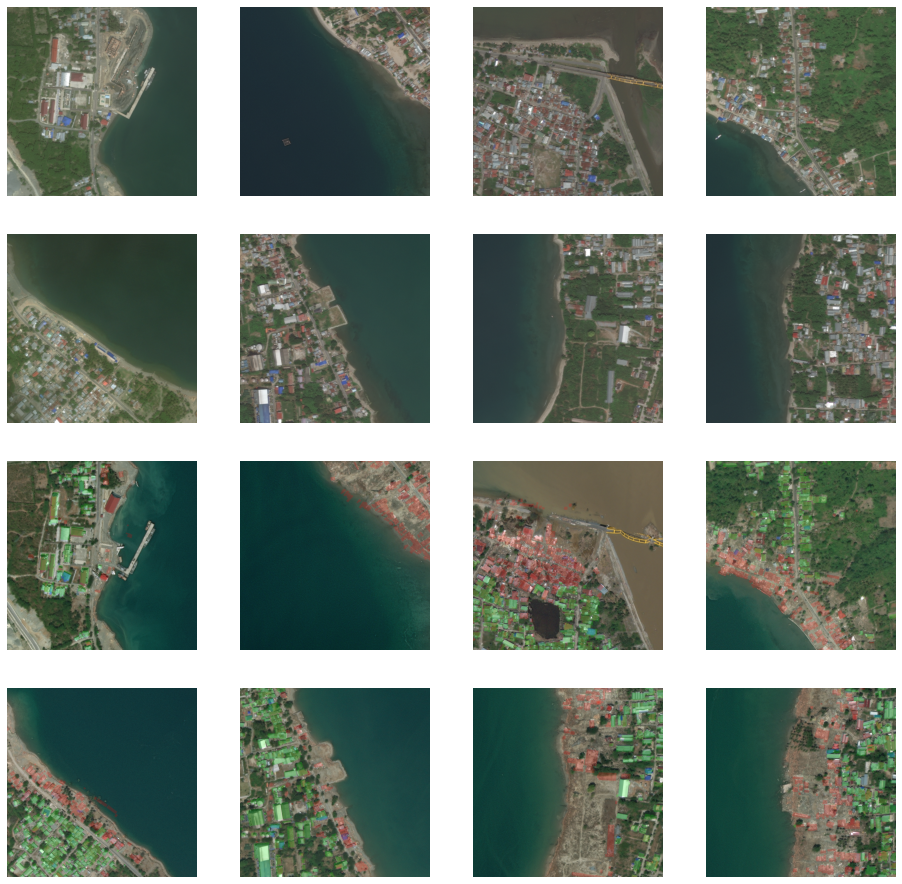

In [22]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

mapping_dir = '/content/mapping'


post = []
for names in os.listdir(mapping_dir):
    if names.endswith("After.jpg"):
        post.append(names)
post.sort()

pre = []
for names in os.listdir(mapping_dir):
    if names.endswith("Before.jpg"):
        pre.append(names)
pre.sort()

next_post_pix = [os.path.join(mapping_dir, fname) 
                for fname in post[ pic_index-8:pic_index] 
               ]

next_pre_pix = [os.path.join(mapping_dir, fname) 
                for fname in pre[ pic_index-8:pic_index]
               ]
for i, img_path in enumerate(next_pre_pix + next_post_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Road Extraction

Pre and post road condition

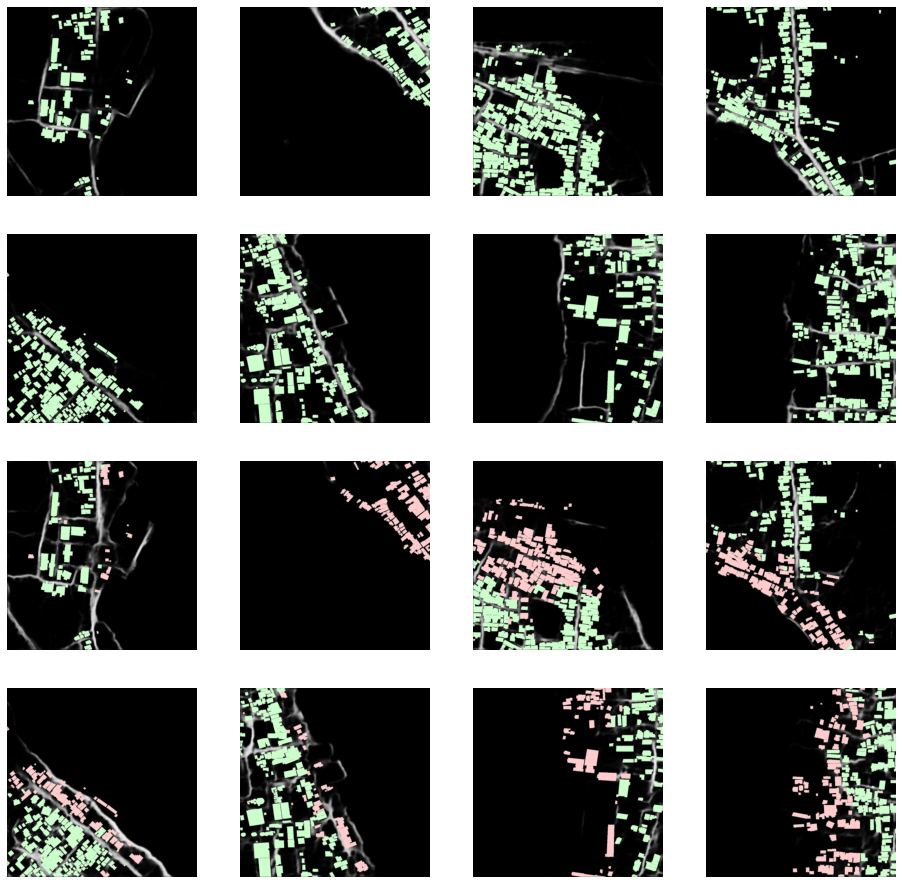

In [23]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

mapping_dir = '/content/road'


post = []
for names in os.listdir(mapping_dir):
    if names.endswith("After.png"):
        post.append(names)
post.sort()

pre = []
for names in os.listdir(mapping_dir):
    if names.endswith("Before.png"):
        pre.append(names)
pre.sort()

next_post_pix = [os.path.join(mapping_dir, fname) 
                for fname in post[ pic_index-8:pic_index] 
               ]

next_pre_pix = [os.path.join(mapping_dir, fname) 
                for fname in pre[ pic_index-8:pic_index]
               ]
for i, img_path in enumerate(next_pre_pix + next_post_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()